CNN ( CNN 3layer + FC ) + 3channel level

In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
from glob import glob
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import ast
import re
import keras
import cv2
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from tqdm import tqdm
import os
print(os.listdir("../input"))
BASE_SIZE = 256
DP_DIR = '../input/shuffle-csvs/'
INPUT_DIR = '../input/quickdraw-doodle-recognition/'
NCSVS = 100
NCATS = 340

In [17]:
classes_path = os.listdir(INPUT_DIR + 'train_simplified/')
classes_path = sorted(classes_path, key=lambda s: s.lower())
class_dict = {x[:-4].replace(" ", "_"):i for i, x in enumerate(classes_path)}
labels = {x[:-4].replace(" ", "_") for i, x in enumerate(classes_path)}

n_labels = len(labels)
print("Number of labels: {}".format(n_labels))

fileList = glob(INPUT_DIR + "train_simplified/*.csv")


BASE_SIZE = 256

img_size = 80
batchsize = 256
line_width = 7

colors = [(255, 0, 0) , (255, 255, 0),  (128, 255, 0),  (0, 255, 0), (0, 255, 128), (0, 255, 255), 
          (0, 128, 255), (0, 0, 255), (128, 0, 255), (255, 0, 255)]

def draw_cv2(raw_strokes, size=256, lw=7, time_color=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE, 3), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = colors[min(t, len(colors)-1)]
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw, lineType=cv2.LINE_AA)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img
    
    
def image_generator(size, batchsize, ks, lw=6):
    while True:
        for k in np.random.permutation(ks):
            filename = os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(k))
            for df in pd.read_csv(filename, chunksize=batchsize):
                df['drawing'] = df['drawing'].apply(ast.literal_eval)
                x = np.zeros((len(df), size, size,3))
                for i, raw_strokes in enumerate(df.drawing.values):
                    x[i,:,:,:] = draw_cv2(raw_strokes, size=size, lw=lw)
                x = x / 255.
                x = x.reshape((len(df), size, size, 3)).astype(np.float32)
                y = keras.utils.to_categorical(df.y, num_classes=NCATS)
                yield x, y

def df_to_image_array(df, size, lw=6):
    df['drawing'] = df['drawing'].apply(ast.literal_eval)
    x = np.zeros((len(df), size, size,3))
    for i, raw_strokes in enumerate(df.drawing.values):
        x[i,:,:,:] = draw_cv2(raw_strokes, size=size, lw=lw)
    x = x.reshape((len(df), size, size, 3)).astype(np.float32)
    return x




train_datagen = image_generator(size=img_size, batchsize=batchsize,ks=99)
from keras.applications.resnet50 import ResNet50, preprocess_input
def test_generator(img_size, batchsize, lw=6):
    while True:
        for df in pd.read_csv(os.path.join(INPUT_DIR,"test_simplified.csv"), chunksize=batchsize):
            df['drawing'] = df['drawing'].apply(ast.literal_eval)
            x = np.zeros((len(df), img_size, img_size, 3))
            for i, raw_strokes in enumerate(df.drawing.values):
                x[i, :, :, :] = draw_cv2(raw_strokes, size=img_size, lw=lw)
            yield x, preprocess_input(x).astype(np.float32)
            
test_datagen = test_generator(img_size, batchsize, line_width)


STEPS = 1200
epochs = 15

Number of labels: 340


TEST data를 통해 시각화 - 컬리입힘. stroke 하는 시간을 기준으로 하여 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

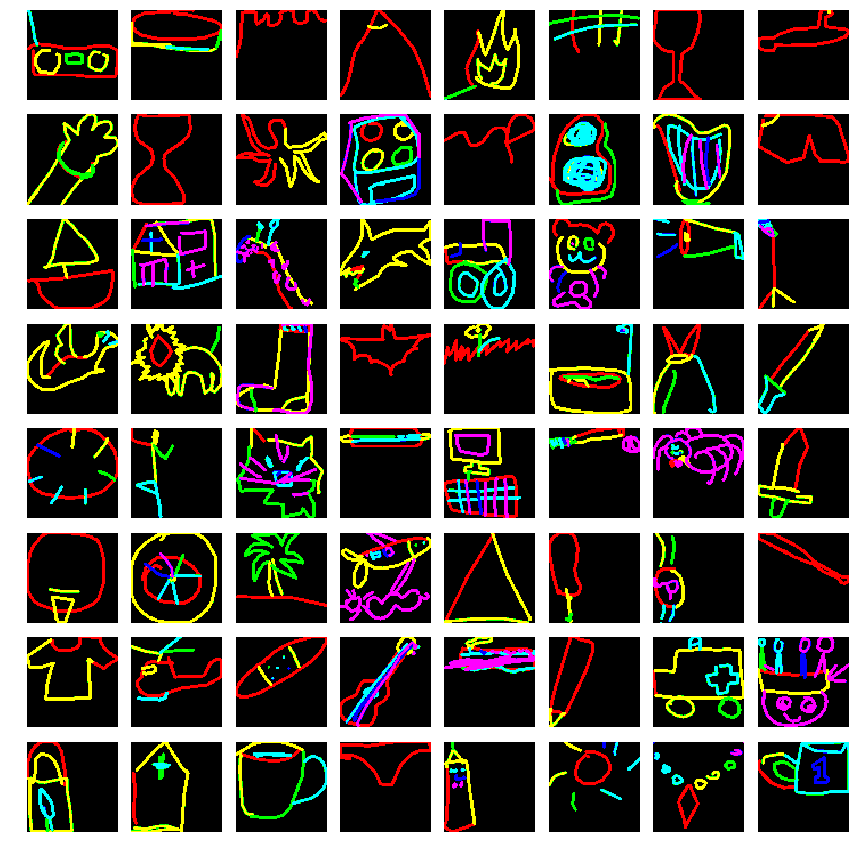

In [20]:
test_datagen = test_generator(img_size, batchsize, line_width)
x, xi = next(test_datagen)
n = 8
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(12, 12))
for i in range(n**2):
    ax = axs[i // n, i % n]
    ax.imshow(x[i])
    ax.axis('off')
plt.tight_layout()
fig.savefig('gs.png', dpi=300)
plt.show();

In [24]:
import ast
import re
import keras
import cv2

valid_df = pd.read_csv(os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(NCSVS - 1)), nrows=30000)


x_valid = df_to_image_array(valid_df, img_size)
y_valid = keras.utils.to_categorical(valid_df.y, num_classes=NCATS)
print(x_valid.shape)

(30000, 80, 80, 3)


In [27]:
import keras
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation, Dropout, Flatten
from keras.layers import Reshape, Lambda, BatchNormalization
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.models import Sequential

from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(img_size, img_size,3)))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.1))


cnn_model.add(Flatten())
cnn_model.add(Dense(680, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(n_labels, activation='softmax'))
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 80, 80, 32)        896       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 20, 20, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 20, 20, 64)        36928     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 10, 10, 64)        0         
__________

In [29]:
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import top_k_categorical_accuracy

def top_3_accuracy(x,y): 
    t3 = top_k_categorical_accuracy(x,y, 3)
    return t3

reduceLROnPlat = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=3, 
                                   verbose=1, mode='auto', min_delta=0.005, cooldown=5, min_lr=0.0001)
earlystop = EarlyStopping(monitor='val_top_3_accuracy', mode='max', patience=5) 
callbacks = [reduceLROnPlat, earlystop]

cnn_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', top_3_accuracy])


hist = cnn_model.fit_generator(
    train_datagen, steps_per_epoch=STEPS, epochs=1, verbose=1,
    validation_data=(x_valid, y_valid),
    callbacks = callbacks
)

Epoch 1/2
1200/1200 [==============================] - 304s 253ms/step - loss: 2.0447 - acc: 0.5243 - top_3_accuracy: 0.7215 - val_loss: 12.1108 - val_acc: 0.2445 - val_top_3_accuracy: 0.9420
Epoch 2/2
   3/1200 [..............................] - ETA: 52s - loss: 1.9900 - acc: 0.5430 - top_3_accuracy: 0.7344

/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:1109: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_categorical_accuracy` which is not available. Available metrics are: val_loss,val_acc,val_top_3_accuracy,loss,acc,top_3_accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1200/1200 [==============================] - 299s 249ms/step - loss: 1.9572 - acc: 0.5433 - top_3_accuracy: 0.7387 - val_loss: 13.2120 - val_acc: 0.1767 - val_top_3_accuracy: 0.9310


In [30]:
cnnmodel_json = cnn_model.to_json()
with open("cnn_model.json", "w") as json_file : 
    json_file.write(cnnmodel_json)



cnn_model.save_weights("cnn_color.h5")
print("Saved model to disk")

Saved model to disk
